In [2]:

import torchvision.datasets as datasets
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import numpy as np
import torch.nn as nn
import torch
from torchvision import models
from torchsummary import summary


def accuracy(outputs,labels):
    _,pred = torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(pred==labels).item()/len(pred))

def training_step(batch, model):
            image,label = batch
            out = model(image.cuda())
            loss = loss_fn(out,label.cuda())
            return loss
    
def test_step(batch, model):
            image,label = batch
            out = model(image.cuda())
            loss = loss_fn(out,label.cuda())
            acc = accuracy(out, label.cuda())
            return {'test_loss': loss.detach(), 'test_acc': acc}
    
def training_result(outputs):
            batch_loss = [i['test_loss'] for i in outputs]
            epoch_loss = torch.stack(batch_loss).mean()
            batch_acc = [i['test_acc'] for i in outputs]
            epoch_acc = torch.stack(batch_acc).mean()  
            return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}
    
def epoch_result(epoch,result):
            print("Epoch [{}], train_loss: {:.4f}, test_loss: {:.4f}, test_acc: {:.4f}".format(
                epoch, result['train_loss'], result['test_loss'], result['test_acc']))

def get_default_device():
    """Pick GPU if available, else CPU"""
    return torch.device('cuda')
       
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
def evaluation(model,test_loader):
    model.eval()
    output = [test_step(batch, model) for batch in test_loader] 
    return training_result(output)

def fit(epochs,model,lr,train_loader,test_loader,optimizer):
    history = []
    for epoch in range(epochs):
        train_loss = []
        model.train()
        for batch in train_loader:
            loss = training_step(batch, model)
            train_loss.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluation(model,test_loader)
        result['train_loss'] = torch.stack(train_loss).mean().item()
        epoch_result(epoch,result)
    return result['test_acc']
                             
"""
kernel_size1: 1, 3, 5
kernel_size2: 1, 3, 5
out channel_1: 3, 6, 9
out_channel_2: 12, 16, 24
l_out_dim1: 20, 60, 80, 120
l_out_dim2: 21, 42, 84 

search space -> 2 * 3 * 3 * 4 * 3

"""
class LeNet_MNIST(nn.Module):
    def __init__(self, out_channels1 = 6, kernel_size1 = 5, 
                 kernel_size2 = 5, out_channels2 = 16,
                 l_out_dim1 = 120, l_out_dim2 = 84):
        super(LeNet_MNIST,self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = out_channels1, kernel_size = (kernel_size1, kernel_size1), padding = 'same')
        self.conv2 = nn.Conv2d(in_channels = out_channels1, out_channels = out_channels2, kernel_size = (kernel_size2, kernel_size2), padding = 'same')
        self.L1 = nn.Linear(out_channels2 * 7 * 7, l_out_dim1)
        self.L2 = nn.Linear(l_out_dim1, l_out_dim2)
        self.L3 = nn.Linear(l_out_dim2, 10)
        self.pool = nn.MaxPool2d(2, stride=2)
    def forward(self,x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = x.view(x.size()[0], -1)
        x = self.L1(x)
        x = self.L2(x)
        x = self.L3(x)    
        return x
    


In [ ]:
train = datasets.MNIST(root='data',train=True,transform=ToTensor(),download=True)
test = datasets.MNIST(root='data',train=False,transform=ToTensor(),download=True)
batch_size = 128
train_loader = DataLoader(train,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test,batch_size=batch_size,shuffle=False)

loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
test_dl = DeviceDataLoader(test_loader, device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.01
random_seed = 0
torch.manual_seed(random_seed)

kernel_size = [1, 3, 5]
out_channel_1 = [3, 6, 9]
out_channel_2 = [12, 16, 24]
l_out_dim1 = [20, 60, 80, 120]
l_out_dim2 = [21, 42, 84]

search_space = []
for k1 in kernel_size:
  for k2 in kernel_size:
    for o1 in out_channel_1:
      for o2 in out_channel_2:
        for l1 in l_out_dim1:
          for l2 in l_out_dim2:
              search_space.append([k1, k2, o1, o2, l1, l2])
print('search space: ', len(search_space))

parameter_budget = 0.06
best_acc = 0
best_hyperparameter = None
hyperparameters = []
accs = []
ps = []
l = 0
for i in search_space:
  model = LeNet_MNIST(out_channels1 = i[2], kernel_size1 = i[0], 
                 kernel_size2 = i[1], out_channels2 = i[3],
                 l_out_dim1 = i[4], l_out_dim2 = i[5])
  summary(model, (1, 28, 28))
  parameter_size = sum(p.numel() for p in model.parameters()) * 4/(1024 * 1024)
  print('parameter_size: ', parameter_size)
  if parameter_size > parameter_budget:
    print('skip this selection')
    continue
  ps.append(parameter_size)
  optimizer = optim.Adam(model.parameters(), lr=0.1)
  to_device(model, device)
  acc = fit(num_epochs,model,lr, train_dl, test_dl, opt_func)
  hyperparameters.append(i)
  accs.append(acc)
  if acc > best_acc:
    best_acc = acc
    best_hyperparameter = i
  print(l, hyperparameters, accs)
  l += 1
print(min(ps), max(ps))
print('best_hyperparamer: ', best_hyperparameter, 'best test acc', best_acc)


Streaming output truncated to the last 5000 lines.
            Conv2d-3           [-1, 24, 14, 14]             240
         MaxPool2d-4             [-1, 24, 7, 7]               0
            Linear-5                   [-1, 60]          70,620
            Linear-6                   [-1, 42]           2,562
            Linear-7                   [-1, 10]             430
Total params: 74,086
Trainable params: 74,086
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.28
Estimated Total Size (MB): 0.40
----------------------------------------------------------------
parameter_size:  0.28261566162109375
skip this selection
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 28, 28]             234
         MaxPool2d-2            [-1, 9, 14, 14]               0


In [ ]:
h = [[1, 1, 3, 12, 20, 21], [1, 1, 3, 12, 20, 42], [1, 1, 3, 12, 20, 84], [1, 1, 6, 12, 20, 21], [1, 1, 6, 12, 20, 42], [1, 1, 6, 12, 20, 84], [1, 1, 9, 12, 20, 21], [1, 1, 9, 12, 20, 42], [1, 1, 9, 12, 20, 84], [1, 3, 3, 12, 20, 21], [1, 3, 3, 12, 20, 42], [1, 3, 3, 12, 20, 84], [1, 3, 6, 12, 20, 21], [1, 3, 6, 12, 20, 42], [1, 3, 6, 12, 20, 84], [1, 3, 9, 12, 20, 21], [1, 3, 9, 12, 20, 42], [1, 3, 9, 12, 20, 84], [1, 5, 3, 12, 20, 21], [1, 5, 3, 12, 20, 42], [1, 5, 3, 12, 20, 84], [1, 5, 6, 12, 20, 21], [1, 5, 6, 12, 20, 42], [1, 5, 9, 12, 20, 21], [3, 1, 3, 12, 20, 21], [3, 1, 3, 12, 20, 42], [3, 1, 3, 12, 20, 84], [3, 1, 6, 12, 20, 21], [3, 1, 6, 12, 20, 42], [3, 1, 6, 12, 20, 84], [3, 1, 9, 12, 20, 21], [3, 1, 9, 12, 20, 42], [3, 1, 9, 12, 20, 84], [3, 3, 3, 12, 20, 21], [3, 3, 3, 12, 20, 42], [3, 3, 3, 12, 20, 84], [3, 3, 6, 12, 20, 21], [3, 3, 6, 12, 20, 42], [3, 3, 6, 12, 20, 84], [3, 3, 9, 12, 20, 21], [3, 3, 9, 12, 20, 42], [3, 3, 9, 12, 20, 84], [3, 5, 3, 12, 20, 21], [3, 5, 3, 12, 20, 42], [3, 5, 3, 12, 20, 84], [3, 5, 6, 12, 20, 21], [3, 5, 6, 12, 20, 42], [3, 5, 9, 12, 20, 21], [5, 1, 3, 12, 20, 21], [5, 1, 3, 12, 20, 42], [5, 1, 3, 12, 20, 84], [5, 1, 6, 12, 20, 21], [5, 1, 6, 12, 20, 42], [5, 1, 6, 12, 20, 84], [5, 1, 9, 12, 20, 21], [5, 1, 9, 12, 20, 42], [5, 1, 9, 12, 20, 84], [5, 3, 3, 12, 20, 21], [5, 3, 3, 12, 20, 42], [5, 3, 3, 12, 20, 84], [5, 3, 6, 12, 20, 21], [5, 3, 6, 12, 20, 42], [5, 3, 6, 12, 20, 84], [5, 3, 9, 12, 20, 21], [5, 3, 9, 12, 20, 42], [5, 3, 9, 12, 20, 84], [5, 5, 3, 12, 20, 21], [5, 5, 3, 12, 20, 42], [5, 5, 3, 12, 20, 84], [5, 5, 6, 12, 20, 21], [5, 5, 6, 12, 20, 42], [5, 5, 9, 12, 20, 21]] 
a_s = [0.8731210231781006, 0.8803402185440063, 0.885977029800415, 0.8805379867553711, 0.8705498576164246, 0.8889438509941101, 0.8841969966888428, 0.8466178774833679, 0.3303995132446289, 0.9215783476829529, 0.9586629867553711, 0.9611352682113647, 0.9618275165557861, 0.9701344966888428, 0.9144580960273743, 0.9676621556282043, 0.9716178774833679, 0.9651898741722107, 0.974782407283783, 0.9708267450332642, 0.9563884735107422, 0.9696400165557861, 0.9704311490058899, 0.9734968543052673, 0.902492105960846, 0.9185126423835754, 0.9481803774833679, 0.891811728477478, 0.9508504867553711, 0.9652887582778931, 0.912282407283783, 0.9450158476829529, 0.9526305198669434, 0.966969907283783, 0.9678599834442139, 0.9654865264892578, 0.9738923907279968, 0.9732001423835754, 0.9644976258277893, 0.9738923907279968, 0.9724090099334717, 0.9727057218551636, 0.9721123576164246, 0.9717167615890503, 0.974782407283783, 0.9755735993385315, 0.9749802350997925, 0.9785403609275818, 0.9238528609275818, 0.9506527185440063, 0.961530864238739, 0.9569817781448364, 0.9512460231781006, 0.9689477682113647, 0.9605419039726257, 0.824070394039154, 0.9448180198669434, 0.0970134511590004, 0.972804605960846, 0.971914529800415, 0.969936728477478, 0.9717167615890503, 0.9744857549667358, 0.96875, 0.9736946225166321, 0.9750791192054749, 0.9652887582778931, 0.9735957384109497, 0.9732001423835754, 0.9779469966888428, 0.9782436490058899, 0.973397970199585]


In [ ]:
print(ps)

[0.047664642333984375, 0.05014801025390625, 0.05511474609375, 0.047824859619140625, 0.0503082275390625, 0.05527496337890625, 0.047985076904296875, 0.05046844482421875, 0.0554351806640625, 0.048763275146484375, 0.05124664306640625, 0.05621337890625, 0.050022125244140625, 0.0525054931640625, 0.05747222900390625, 0.051280975341796875, 0.05376434326171875, 0.0587310791015625, 0.050960540771484375, 0.05344390869140625, 0.05841064453125, 0.054416656494140625, 0.0569000244140625, 0.057872772216796875, 0.047756195068359375, 0.05023956298828125, 0.055206298828125, 0.048007965087890625, 0.0504913330078125, 0.05545806884765625, 0.048259735107421875, 0.05074310302734375, 0.0557098388671875, 0.048854827880859375, 0.05133819580078125, 0.056304931640625, 0.050205230712890625, 0.0526885986328125, 0.05765533447265625, 0.051555633544921875, 0.05403900146484375, 0.0590057373046875, 0.051052093505859375, 0.05353546142578125, 0.058502197265625, 0.054599761962890625, 0.0570831298828125, 0.058147430419921875

Text(0, 0.5, 'test accuracy')

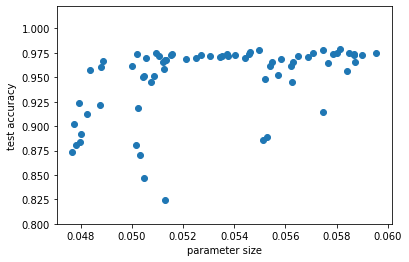

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(ps, a_s)
plt.ylim(0.8, )
plt.xlabel('parameter size')
plt.ylabel('test accuracy')

In [80]:
# N -> input channel,
# M -> output channel,
# C -> column,
# R -> row,
# K -> kernel_size,
# S -> stride,
import math
"""Assume the structure of CNN is fixed"""
def gen_CNN_configuration(configuration:list):
  # configuration -> k1, k2, o1, o2, l1, l2
  k1, k2, o1, o2, l1, l2 = configuration
  CNN = np.array([[1, o1, 28, 28, k1, 1],
  [o1, o2, 28, 28, k2, 1],
  [1, 1, o2 * 7 * 7, l1, 1, 1],
  [l1, l2, 1, 1, 1, 1],
  [l2, 10, 1, 1, 1, 1]],dtype=np.int64)
  return CNN 

def predict_latency(configuration:list, tile_configuration:list):
    # tile_configuration = [Tn, Tm, Tr, Tc]
    CNN = gen_CNN_configuration(configuration)
    Tn, Tm, Tr, Tc = tile_configuration
    NUM_layer = CNN.shape[0]
    NUM_DSP = math.floor(6833/5)
    BRAM = 8.17+33.75 #MB
    DATA_TYPE = 4 #B;
    DDR_BW = 77 # GB/s
    freq = 250 #MHz
    per_layer=np.ones((NUM_layer),dtype=np.float64) * 0.001
    for i in range(0,NUM_layer):
        N=CNN[i][0]
        M=CNN[i][1]
        C=CNN[i][2]
        R=CNN[i][3]
        K=CNN[i][4]
        S=CNN[i][5]
  
        B_in=Tn*(S*Tr+K-S)*(S*Tc+K-S)*DATA_TYPE
        B_wght=Tm*Tn*K*K*DATA_TYPE
        B_out=Tm*Tr*Tc*DATA_TYPE
        BRAM_req = 2 * float(B_in + B_wght + B_out) / (1024 * 1024)
        if (BRAM_req > BRAM):
            #print('Exceed BRAM limitation!', Tn, Tm, Tr, Tc, BRAM_req)
            return -0.0001

        a_in = math.ceil(M/Tm)*math.ceil(N/Tn)*math.ceil(R/Tr)*math.ceil(C/Tc)
        a_wght = a_in
        a_out = math.ceil(M/Tm)*math.ceil(R/Tr)*math.ceil(C/Tc)
        Comp_cyc = np.float64(math.ceil(M/Tm)*math.ceil(N/Tn)*math.ceil(R/Tr)*math.ceil(C/Tc)*(Tr*Tc*K*K))#Cycle number
        Data_access = np.float64(a_in*B_in+a_wght*B_wght+a_out*B_out)#Data size：B
        Comm_cyc = (Data_access/(1e9*DDR_BW))*(freq*1e6)
        Exe_cyc = max(Comm_cyc, Comp_cyc)
        per_layer[i] = Exe_cyc 
    
    Exe_total=np.sum(per_layer)

    return Exe_total


In [90]:
import copy
import random
import numpy as np

class EvolutionFinder:
    def __init__(self, train_loader, test_loader):
        # evolution hyper-parameters
        self.population_size = 50
        self.max_time_budget = 12
        self.parent_ratio = 0.3
        self.mutation_ratio = 0.5
        self.parameter_constraint = 0.1
        # k1, k2, o1, o2, l1, l2
        self.N_max=48
        self.M_max=48

        self.search_mode = 2# 1 is combined search # 2 is independent search
        self.search_pool = [[1, 3, 5],
                       [1, 3, 5],
                       [3, 6, 9, 12, 16],
                       [12, 16, 24, 48],
                       [20, 60, 80, 120, 200],
                       [21, 42, 84, 168], 
                       list(range(1, self.N_max)), 
                       list(range(1, self.M_max)),
                       list(range(1, 200)),
                       list(range(1, 200))
                      ]
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.epoch = 1

    def search_latency(self, configuration:list, tile_configuration:list):
        min_latency = 1e12
        best_tiles = None
        for Tn in range(1, max(configuration) + 1, int(max(configuration)/5)):
          for Tm in range(1, max(configuration) + 1, int(max(configuration)/5)): 
            for Tr in range(1, max(configuration) + 1, int(max(configuration)/5)):
              for Tc in range(1, max(configuration) + 1, int(max(configuration)/5)):
                la = predict_latency(configuration = configuration, tile_configuration = [Tn, Tm, Tr, Tc])
                if la < min_latency:
                  min_latency = la
                  best_tiles = [Tn, Tm, Tr, Tc]
        return min_latency, best_tiles

    def random_sample_hyp(self):
        sample = []
        for s in self.search_pool:
            random_index = random.randint(0, len(s)-1)
            sample.append(s[random_index])
        return sample

    def random_valid_sample(self):
        while True:
            sample = self.random_sample_hyp()
            model = LeNet_MNIST(out_channels1 = sample[2], kernel_size1 = sample[0], 
                 kernel_size2 = sample[1], out_channels2 = sample[3],
                 l_out_dim1 = sample[4], l_out_dim2 = sample[5])
            parameter_size = sum(p.numel() for p in model.parameters()) * 4/(1024 * 1024)
            if self.search_mode == 1:
                latency = predict_latency(sample[:6], sample[6:])
            else:
                latency, best_tiles = self.search_latency(sample[:6], sample[6:])
            sample[6] = best_tiles[0]
            sample[7] = best_tiles[1]
            sample[8] = best_tiles[2]
            sample[9] = best_tiles[3]
            if parameter_size < self.parameter_constraint:
                return sample, parameter_size, latency

    def mutate_sample(self, sample):
        while True:
            new_sample = copy.copy(sample)
            for i in range(len(new_sample)):
                p = random.random()
                if p < self.mutation_ratio:
                    new_sample[i] = random.choice(self.search_pool[i])

            model = LeNet_MNIST(out_channels1 = new_sample[2], kernel_size1 = new_sample[0], 
                 kernel_size2 = new_sample[1], out_channels2 = new_sample[3],
                 l_out_dim1 = new_sample[4], l_out_dim2 = new_sample[5])
            parameter_size = sum(p.numel() for p in model.parameters()) * 4/(1024 * 1024)
            if self.search_mode == 1:
                latency = predict_latency(sample[:6], sample[6:])
            else:
                latency, best_tiles = self.search_latency(sample[:6], sample[6:])
            sample[6] = best_tiles[0]
            sample[7] = best_tiles[1]
            sample[8] = best_tiles[2]
            sample[9] = best_tiles[3]
            if parameter_size < self.parameter_constraint:
                return sample, parameter_size, latency

    def crossover_sample(self, sample1, sample2):
        while True:
            new_sample = copy.copy(sample1)
            for i in range(len(new_sample)):
              new_sample[i] = random.choice([sample1[i], sample2[i]])

            model = LeNet_MNIST(out_channels1 = new_sample[2], kernel_size1 = new_sample[0], 
                 kernel_size2 = new_sample[1], out_channels2 = new_sample[3],
                 l_out_dim1 = new_sample[4], l_out_dim2 = new_sample[5])
            parameter_size = sum(p.numel() for p in model.parameters()) * 4/(1024 * 1024)
            if self.search_mode == 1:
                latency = predict_latency(new_sample[:6], new_sample[6:])
            else:
                latency, best_tiles = self.search_latency(new_sample[:6], new_sample[6:])
            new_sample[6] = best_tiles[0]
            new_sample[7] = best_tiles[1]
            new_sample[8] = best_tiles[2]
            new_sample[9] = best_tiles[3]
            if parameter_size < self.parameter_constraint:
                return new_sample, parameter_size, latency
    
    def get_acc(self, model):
        optimizer = optim.Adam(model.parameters(), lr=0.1)
        model.cuda()
        acc = fit(epochs = self.epoch, model = model, lr = 0.1, 
            train_loader = self.train_loader, test_loader = self.test_loader, optimizer = optimizer)
        return round(acc, 2)

    def run_evolution_search(self):
        """Run a single roll-out of regularized evolution to a fixed time budget."""
        
        list_all = []
        mutation_numbers = int(round(self.mutation_ratio * self.population_size))
        parents_size = int(round(self.parent_ratio * self.population_size))

        best_valids = [-100]
        population = []  # (validation, sample, latency) tuples
        child_pool = []
        p_pool = []
        latency_pool = []
        best_info = None
       
        for _ in range(self.population_size):
            sample, parameter_size, latency = self.random_valid_sample()
            child_pool.append(sample)
            p_pool.append(parameter_size)
            latency_pool.append(latency)
            print(latency)
        accs = []
        for c in child_pool:
          model = LeNet_MNIST(out_channels1 = c[2], kernel_size1 = c[0], 
                 kernel_size2 = c[1], out_channels2 = c[3],
                 l_out_dim1 = c[4], l_out_dim2 = c[5])
          accs.append(self.get_acc(model.cuda()))
        for i in range(self.population_size):
            population.append([accs[i], child_pool[i], p_pool[i], latency_pool[i]])
        print('population from random sample stage', population)
        for i in range(self.max_time_budget):
                parents = sorted(population, key=lambda x: x[0] + 10000/x[3])[::-1][:parents_size]
                print('!!!!!!!!!!! epoch ', i, parents)
                list_all.append(parents)
                acc = parents[0][0]
               
                if acc > best_valids[-1]:
                    best_valids.append(acc)
                    best_info = parents[0]
                else:
                    best_valids.append(best_valids[-1])

                population = parents
                child_pool = []
                p_pool = []
                latency_pool = []

                for j in range(mutation_numbers):
                    par_sample = population[np.random.randint(parents_size)][1]
                    # Mutate
                    new_sample, p, latency = self.mutate_sample(par_sample)
                    child_pool.append(new_sample)
                    p_pool.append(p)
                    latency_pool.append(latency)

                for j in range(self.population_size - mutation_numbers):
                    par_sample1 = population[np.random.randint(parents_size)][1]
                    par_sample2 = population[np.random.randint(parents_size)][1]
                    # Crossover
                    new_sample, p, latency = self.crossover_sample(
                        par_sample1, par_sample2
                    )
                    child_pool.append(new_sample)
                    p_pool.append(p)
                    latency_pool.append(latency)

                accs = []
                for c in child_pool:
                    model = LeNet_MNIST(out_channels1 = c[2], kernel_size1 = c[0], 
                      kernel_size2 = c[1], out_channels2 = c[3],
                      l_out_dim1 = c[4], l_out_dim2 = c[5])
                    accs.append(self.get_acc(model.cuda()))
                for j in range(self.population_size):
                    population.append(
                        [accs[j], child_pool[j], p_pool[j], latency_pool[j]]
                    )

        return best_valids, best_info, list_all

In [91]:
train = datasets.MNIST(root='data',train=True,transform=ToTensor(),download=True)
test = datasets.MNIST(root='data',train=False,transform=ToTensor(),download=True)
batch_size = 128
train_loader = DataLoader(train,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test,batch_size=batch_size,shuffle=False)

loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')
device = get_default_device()
train_dl = DeviceDataLoader(train_loader, device)
test_dl = DeviceDataLoader(test_loader, device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
opt_func = torch.optim.Adam
random_seed = 0
torch.manual_seed(random_seed)

E = EvolutionFinder(train_loader, test_loader)
best_test, best_info, list_all = E.run_evolution_search()


13860.0
47388.0
36168.0
40350.0
32604.0
39996.0
28776.0
-0.0001
-0.0001
39510.0
62304.0
17820.0
47520.0
21384.0
25695.0
-0.0001
-0.0001
-0.0001
-0.0001
13860.0
-0.0001
47388.0
-0.0001
47388.0
55308.0
13470.0
-0.0001
44270.0
38390.0
34470.0
-0.0001
13992.0
33132.0
47520.0
-0.0001
43560.0
47520.0
-0.0001
28644.0
60726.27272727273
42450.0
-0.0001
36168.0
37550.0
17952.0
40128.0
36168.0
62172.0
-0.0001
24110.0
Epoch [0], train_loss: 492.5730, test_loss: 48.9330, test_acc: 0.8806
Epoch [0], train_loss: 3042.3928, test_loss: 23.5885, test_acc: 0.9453
Epoch [0], train_loss: 1320.4386, test_loss: 19.2009, test_acc: 0.9519
Epoch [0], train_loss: 522.8330, test_loss: 29.1986, test_acc: 0.9334
Epoch [0], train_loss: 643.0483, test_loss: 21.6455, test_acc: 0.9480
Epoch [0], train_loss: 2604.7168, test_loss: 22.7593, test_acc: 0.9490
Epoch [0], train_loss: 1333.9077, test_loss: 20.9746, test_acc: 0.9489
Epoch [0], train_loss: 16831.1934, test_loss: 54.4114, test_acc: 0.9313
Epoch [0], train_loss: 8

Results of combined search

In [5]:
l2 = [
[[0.95, [3, 1, 9, 12, 20, 42, 38, 44, 18, 36], 0.05074310302734375, 39296.31168831168], [0.94, [1, 3, 6, 12, 20, 42, 38, 39, 41, 50], 0.0525054931640625, 53588.70129870129], [0.94, [3, 1, 12, 24, 20, 42, 13, 42, 56, 46], 0.0964508056640625, 108192.0], [0.96, [5, 1, 12, 12, 20, 168, 43, 13, 28, 109], 0.06662750244140625, 149548.0], [0.96, [5, 3, 6, 12, 20, 42, 21, 36, 20, 96], 0.0530548095703125, 151680.0], [0.96, [3, 3, 16, 12, 20, 21, 10, 36, 5, 189], 0.054706573486328125, 172935.0], [0.92, [1, 3, 12, 16, 20, 42, 12, 33, 40, 115], 0.0716400146484375, 115000.0], [0.95, [3, 5, 3, 12, 20, 21, 15, 32, 81, 45], 0.051052093505859375, 189540.0], [0.96, [3, 1, 16, 12, 20, 21, 42, 22, 99, 188], 0.048847198486328125, 297792.0], [0.93, [5, 5, 16, 12, 20, 84, 43, 25, 30, 82], 0.07485198974609375, 157440.0], [0.95, [3, 1, 9, 24, 20, 42, 11, 43, 53, 198], 0.09606170654296875, 230868.0], [0.95, [3, 1, 12, 16, 20, 84, 44, 42, 126, 76], 0.07111358642578125, 255405.81818181815]]
,[[0.95, [3, 1, 16, 12, 20, 21, 13, 36, 5, 46], 0.048847198486328125, 28060.0], [0.96, [5, 1, 9, 16, 20, 42, 31, 44, 18, 27], 0.06639862060546875, 39296.31168831168], [0.95, [3, 1, 9, 12, 20, 42, 38, 44, 18, 36], 0.05074310302734375, 39296.31168831168], [0.95, [3, 1, 12, 12, 20, 168, 43, 36, 5, 109], 0.06589508056640625, 51884.09090909091], [0.94, [1, 3, 6, 12, 20, 42, 38, 39, 41, 50], 0.0525054931640625, 53588.70129870129], [0.87, [1, 1, 16, 16, 20, 42, 23, 44, 144, 36], 0.0660552978515625, 39296.31168831168], [0.93, [1, 3, 6, 12, 20, 42, 38, 39, 70, 50], 0.0525054931640625, 53588.70129870129], [0.93, [1, 3, 16, 12, 20, 84, 43, 25, 30, 82], 0.06166839599609375, 59040.0], [0.94, [1, 3, 6, 12, 20, 42, 21, 33, 20, 115], 0.0525054931640625, 69000.0], [0.95, [3, 1, 9, 12, 20, 42, 38, 44, 5, 189], 0.05074310302734375, 76565.79220779221], [0.96, [3, 1, 9, 24, 20, 42, 11, 43, 53, 36], 0.09606170654296875, 93492.0], [0.88, [1, 1, 6, 12, 20, 42, 38, 25, 130, 166], 0.0503082275390625, 53588.70129870129]]
,[[0.86, [1, 1, 16, 12, 20, 42, 23, 33, 20, 36], 0.05084228515625, 18000.0], [0.95, [3, 1, 12, 12, 20, 21, 13, 36, 5, 46], 0.048511505126953125, 26680.0], [0.96, [3, 1, 12, 12, 20, 21, 13, 36, 5, 46], 0.048511505126953125, 28060.0], [0.95, [3, 1, 16, 12, 20, 21, 13, 36, 5, 46], 0.048847198486328125, 28060.0], [0.94, [3, 1, 16, 12, 20, 168, 22, 32, 171, 26], 0.06623077392578125, 28060.0], [0.93, [1, 3, 16, 12, 20, 21, 43, 36, 5, 46], 0.054218292236328125, 27784.675324675325], [0.95, [3, 1, 6, 12, 20, 42, 38, 25, 18, 36], 0.0504913330078125, 37584.0], [0.96, [5, 1, 9, 16, 20, 42, 31, 44, 18, 27], 0.06639862060546875, 39296.31168831168], [0.95, [3, 1, 9, 12, 20, 42, 38, 44, 18, 36], 0.05074310302734375, 39296.31168831168], [0.94, [3, 1, 16, 12, 20, 21, 43, 25, 5, 82], 0.048847198486328125, 38540.0], [0.94, [3, 1, 9, 12, 20, 42, 38, 44, 18, 36], 0.05074310302734375, 39296.31168831168], [0.94, [3, 1, 6, 12, 20, 21, 16, 24, 18, 82], 0.048007965087890625, 39296.31168831168]]
,[[0.87, [1, 1, 16, 12, 20, 42, 23, 36, 5, 46], 0.05084228515625, 15640.0], [0.94, [5, 1, 6, 12, 20, 168, 23, 46, 20, 86], 0.06575775146484375, 18000.0], [0.88, [1, 1, 16, 12, 20, 42, 23, 33, 20, 36], 0.05084228515625, 18000.0], [0.85, [1, 1, 12, 12, 20, 21, 23, 36, 20, 46], 0.048145294189453125, 17480.0], [0.86, [1, 1, 16, 12, 20, 42, 23, 33, 20, 36], 0.05084228515625, 18000.0], [0.87, [1, 1, 16, 12, 20, 42, 38, 44, 20, 36], 0.05084228515625, 18786.285714285714], [0.96, [3, 1, 12, 12, 20, 21, 13, 36, 5, 46], 0.048511505126953125, 26680.0], [0.96, [3, 1, 12, 12, 20, 42, 20, 5, 5, 162], 0.050994873046875, 26680.0], [0.94, [3, 1, 16, 12, 20, 21, 38, 44, 5, 36], 0.048847198486328125, 25938.597402597403], [0.95, [3, 5, 12, 12, 20, 21, 25, 36, 77, 46], 0.061695098876953125, 26680.0], [0.95, [3, 1, 12, 12, 20, 21, 13, 36, 5, 46], 0.048511505126953125, 26680.0], [0.96, [1, 3, 16, 16, 20, 21, 28, 39, 19, 73], 0.07138442993164062, 27784.675324675325]]
,[[0.94, [5, 1, 16, 24, 20, 42, 11, 36, 92, 46], 0.0979461669921875, 15640.0], [0.92, [3, 3, 6, 12, 20, 42, 23, 21, 76, 88], 0.0526885986328125, 15640.0], [0.88, [1, 1, 12, 12, 20, 21, 28, 39, 5, 46], 0.048145294189453125, 15180.0], [0.96, [3, 1, 16, 12, 20, 42, 16, 30, 20, 182], 0.05133056640625, 18000.0], [0.88, [1, 1, 16, 12, 20, 42, 20, 36, 5, 46], 0.05084228515625, 15870.0], [0.87, [1, 1, 16, 12, 20, 42, 23, 36, 5, 46], 0.05084228515625, 15640.0], [0.87, [1, 1, 12, 12, 20, 42, 20, 36, 5, 46], 0.050628662109375, 15870.0], [0.94, [5, 5, 12, 12, 20, 42, 39, 33, 15, 36], 0.064910888671875, 18000.0], [0.94, [1, 5, 12, 12, 20, 42, 23, 5, 122, 96], 0.063812255859375, 18000.0], [0.94, [5, 1, 6, 12, 20, 168, 23, 46, 20, 86], 0.06575775146484375, 18000.0], [0.93, [1, 3, 16, 12, 20, 84, 45, 39, 78, 136], 0.06166839599609375, 18000.0], [0.95, [5, 1, 3, 24, 20, 42, 38, 24, 100, 36], 0.09546661376953125, 18786.285714285714]]
,[[0.95, [1, 5, 16, 16, 20, 21, 38, 39, 135, 171], 0.08700942993164062, 15180.0], [0.96, [5, 1, 6, 12, 20, 21, 23, 36, 5, 77], 0.048374176025390625, 15640.0], [0.95, [5, 1, 16, 12, 20, 168, 20, 36, 114, 46], 0.06720733642578125, 15870.0], [0.94, [1, 5, 16, 12, 20, 42, 23, 10, 112, 86], 0.06842041015625, 15640.0], [0.94, [5, 1, 16, 24, 20, 42, 11, 36, 92, 46], 0.0979461669921875, 15640.0], [0.94, [1, 3, 9, 24, 20, 21, 31, 16, 5, 115], 0.09989547729492188, 15870.0], [0.92, [3, 3, 6, 12, 20, 42, 23, 21, 76, 88], 0.0526885986328125, 15640.0], [0.89, [1, 1, 12, 12, 20, 21, 30, 39, 167, 184], 0.048145294189453125, 15180.0], [0.88, [1, 1, 12, 12, 20, 21, 28, 39, 5, 46], 0.048145294189453125, 15180.0], [0.87, [1, 1, 12, 16, 20, 168, 28, 12, 110, 139], 0.08068084716796875, 15180.0], [0.87, [1, 1, 12, 16, 20, 21, 28, 39, 5, 80], 0.06329727172851562, 15180.0], [0.96, [3, 1, 16, 12, 20, 42, 16, 30, 20, 182], 0.05133056640625, 18000.0]]
,[[0.95, [1, 5, 16, 16, 20, 21, 38, 39, 135, 171], 0.08700942993164062, 15180.0], [0.96, [5, 1, 6, 12, 20, 21, 23, 36, 5, 77], 0.048374176025390625, 15640.0], [0.95, [5, 1, 16, 12, 20, 168, 20, 36, 114, 46], 0.06720733642578125, 15870.0], [0.94, [5, 1, 16, 24, 20, 42, 11, 36, 92, 46], 0.0979461669921875, 15640.0], [0.94, [1, 5, 16, 12, 20, 42, 23, 10, 112, 86], 0.06842041015625, 15640.0], [0.94, [1, 3, 9, 24, 20, 21, 31, 16, 5, 115], 0.09989547729492188, 15870.0], [0.92, [3, 3, 6, 12, 20, 42, 23, 21, 76, 88], 0.0526885986328125, 15640.0], [0.89, [1, 1, 12, 12, 20, 21, 30, 39, 167, 184], 0.048145294189453125, 15180.0], [0.88, [1, 1, 12, 12, 20, 21, 28, 39, 5, 46], 0.048145294189453125, 15180.0], [0.87, [1, 1, 12, 12, 20, 21, 28, 39, 5, 46], 0.048145294189453125, 15180.0], [0.87, [1, 1, 6, 12, 20, 168, 34, 35, 5, 46], 0.06520843505859375, 15180.0], [0.87, [1, 1, 12, 16, 20, 21, 28, 39, 5, 80], 0.06329727172851562, 15180.0]]
,[[0.95, [5, 1, 12, 12, 20, 21, 44, 39, 32, 160], 0.049243927001953125, 15180.0], [0.95, [1, 5, 16, 16, 20, 21, 38, 39, 135, 171], 0.08700942993164062, 15180.0], [0.96, [5, 1, 6, 12, 20, 21, 23, 36, 5, 77], 0.048374176025390625, 15640.0], [0.94, [1, 5, 12, 12, 20, 42, 28, 8, 136, 103], 0.063812255859375, 15180.0], [0.94, [1, 5, 3, 12, 20, 21, 12, 30, 5, 46], 0.050960540771484375, 15180.0], [0.95, [5, 1, 16, 12, 20, 168, 20, 36, 114, 46], 0.06720733642578125, 15870.0], [0.94, [1, 5, 16, 12, 20, 42, 23, 10, 112, 86], 0.06842041015625, 15640.0], [0.94, [5, 1, 16, 24, 20, 42, 11, 36, 92, 46], 0.0979461669921875, 15640.0], [0.94, [1, 3, 9, 24, 20, 21, 31, 16, 5, 115], 0.09989547729492188, 15870.0], [0.92, [3, 3, 6, 12, 20, 42, 23, 21, 76, 88], 0.0526885986328125, 15640.0], [0.89, [1, 1, 12, 12, 20, 21, 30, 39, 167, 184], 0.048145294189453125, 15180.0], [0.88, [1, 1, 12, 16, 20, 168, 37, 14, 129, 37], 0.08068084716796875, 15180.0]]
,[[0.95, [1, 5, 16, 16, 20, 21, 38, 39, 135, 171], 0.08700942993164062, 15180.0], [0.95, [5, 1, 12, 12, 20, 21, 44, 39, 32, 160], 0.049243927001953125, 15180.0], [0.96, [5, 1, 6, 12, 20, 21, 23, 36, 5, 77], 0.048374176025390625, 15640.0], [0.94, [1, 5, 3, 12, 20, 21, 12, 30, 5, 46], 0.050960540771484375, 15180.0], [0.94, [1, 5, 12, 12, 20, 42, 28, 8, 136, 103], 0.063812255859375, 15180.0], [0.95, [5, 1, 16, 12, 20, 168, 20, 36, 114, 46], 0.06720733642578125, 15870.0], [0.94, [5, 1, 16, 24, 20, 42, 11, 36, 92, 46], 0.0979461669921875, 15640.0], [0.94, [1, 5, 16, 12, 20, 42, 23, 10, 112, 86], 0.06842041015625, 15640.0], [0.94, [1, 3, 9, 24, 20, 21, 31, 16, 5, 115], 0.09989547729492188, 15870.0], [0.92, [3, 3, 6, 12, 20, 42, 23, 21, 76, 88], 0.0526885986328125, 15640.0], [0.89, [1, 1, 12, 12, 20, 21, 30, 39, 167, 184], 0.048145294189453125, 15180.0], [0.88, [1, 1, 12, 16, 20, 168, 37, 14, 129, 37], 0.08068084716796875, 15180.0]]
,[[0.95, [5, 1, 12, 12, 20, 21, 44, 39, 32, 160], 0.049243927001953125, 15180.0], [0.95, [1, 5, 16, 16, 20, 21, 38, 39, 135, 171], 0.08700942993164062, 15180.0], [0.96, [5, 1, 6, 12, 20, 21, 23, 36, 5, 77], 0.048374176025390625, 15640.0], [0.94, [1, 5, 12, 12, 20, 42, 28, 8, 136, 103], 0.063812255859375, 15180.0], [0.94, [1, 5, 3, 12, 20, 21, 12, 30, 5, 46], 0.050960540771484375, 15180.0], [0.95, [5, 1, 16, 12, 20, 168, 20, 36, 114, 46], 0.06720733642578125, 15870.0], [0.94, [1, 5, 16, 12, 20, 42, 23, 10, 112, 86], 0.06842041015625, 15640.0], [0.94, [5, 1, 16, 24, 20, 42, 11, 36, 92, 46], 0.0979461669921875, 15640.0], [0.94, [1, 3, 9, 24, 20, 21, 31, 16, 5, 115], 0.09989547729492188, 15870.0], [0.92, [3, 3, 6, 12, 20, 42, 23, 21, 76, 88], 0.0526885986328125, 15640.0], [0.89, [1, 1, 12, 12, 20, 21, 30, 39, 167, 184], 0.048145294189453125, 15180.0], [0.88, [1, 1, 12, 16, 20, 168, 37, 14, 129, 37], 0.08068084716796875, 15180.0]]
,[[0.95, [1, 5, 16, 16, 20, 21, 38, 39, 135, 171], 0.08700942993164062, 15180.0], [0.95, [5, 1, 12, 12, 20, 21, 44, 39, 32, 160], 0.049243927001953125, 15180.0], [0.96, [5, 1, 6, 12, 20, 21, 23, 36, 5, 77], 0.048374176025390625, 15640.0], [0.94, [1, 5, 3, 12, 20, 21, 12, 30, 5, 46], 0.050960540771484375, 15180.0], [0.94, [1, 5, 12, 12, 20, 42, 28, 8, 136, 103], 0.063812255859375, 15180.0], [0.95, [5, 1, 16, 12, 20, 168, 20, 36, 114, 46], 0.06720733642578125, 15870.0], [0.94, [5, 1, 16, 24, 20, 42, 11, 36, 92, 46], 0.0979461669921875, 15640.0], [0.94, [1, 5, 16, 12, 20, 42, 23, 10, 112, 86], 0.06842041015625, 15640.0], [0.94, [1, 3, 9, 24, 20, 21, 31, 16, 5, 115], 0.09989547729492188, 15870.0], [0.92, [3, 3, 6, 12, 20, 42, 23, 21, 76, 88], 0.0526885986328125, 15640.0], [0.89, [1, 1, 12, 12, 20, 21, 30, 39, 167, 184], 0.048145294189453125, 15180.0], [0.88, [1, 1, 12, 16, 20, 168, 37, 14, 129, 37], 0.08068084716796875, 15180.0]]
,[[0.95, [5, 1, 12, 12, 20, 21, 44, 39, 32, 160], 0.049243927001953125, 15180.0], 
  [0.95, [1, 5, 16, 16, 20, 21, 38, 39, 135, 171], 0.08700942993164062, 15180.0], 
  [0.96, [5, 1, 6, 12, 20, 21, 23, 36, 5, 77], 0.048374176025390625, 15640.0], 
  [0.94, [1, 5, 12, 12, 20, 42, 28, 8, 136, 103], 0.063812255859375, 15180.0], 
  [0.94, [1, 5, 3, 12, 20, 21, 12, 30, 5, 46], 0.050960540771484375, 15180.0], 
  [0.95, [5, 1, 16, 12, 20, 168, 20, 36, 114, 46], 0.06720733642578125, 15870.0], 
  [0.94, [1, 5, 16, 12, 20, 42, 23, 10, 112, 86], 0.06842041015625, 15640.0], 
  [0.94, [5, 1, 16, 24, 20, 42, 11, 36, 92, 46], 0.0979461669921875, 15640.0], 
  [0.94, [1, 3, 9, 24, 20, 21, 31, 16, 5, 115], 0.09989547729492188, 15870.0], 
  [0.92, [3, 3, 6, 12, 20, 42, 23, 21, 76, 88], 0.0526885986328125, 15640.0], 
  [0.89, [1, 1, 12, 12, 20, 21, 30, 39, 167, 184], 0.048145294189453125, 15180.0], 
  [0.88, [1, 1, 12, 16, 20, 168, 37, 14, 129, 37], 0.08068084716796875, 15180.0]]
]


Results of Independent Search

In [6]:
l1= [
[[0.87, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.88, [1, 1, 6, 12, 20, 42, 25, 25, 1, 33], 0.0503082275390625, 13860.0], [0.88, [1, 1, 9, 12, 20, 84, 33, 17, 1, 33], 0.0554351806640625, 13992.0], [0.85, [1, 1, 3, 12, 20, 42, 25, 25, 1, 33], 0.05014801025390625, 13860.0], [0.89, [1, 1, 3, 16, 20, 42, 25, 25, 1, 33], 0.06516265869140625, 17820.0], [0.87, [1, 1, 16, 16, 20, 84, 33, 17, 1, 33], 0.07102203369140625, 17952.0], [0.94, [1, 3, 3, 16, 20, 21, 9, 21, 5, 1], 0.06414413452148438, 24110.0], [0.87, [1, 3, 3, 12, 20, 84, 33, 17, 1, 33], 0.05621337890625, 21384.0], [0.95, [3, 3, 9, 12, 20, 42, 25, 25, 1, 33], 0.05403900146484375, 28644.0], [0.95, [3, 3, 6, 12, 20, 84, 33, 17, 1, 33], 0.05765533447265625, 28776.0], [0.88, [1, 1, 3, 24, 20, 42, 9, 25, 1, 9], 0.09519195556640625, 25695.0], [0.96, [3, 1, 16, 24, 20, 42, 25, 25, 1, 33], 0.0969696044921875, 33132.0], [0.95, [3, 3, 3, 16, 20, 42, 25, 25, 1, 33], 0.06671905517578125, 32604.0], [0.96, [5, 1, 16, 12, 20, 21, 9, 21, 5, 1], 0.049823760986328125, 34470.0], [0.97, [5, 1, 16, 16, 20, 21, 9, 21, 5, 1], 0.06503677368164062, 38390.0]]
,[[0.88, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.09519195556640625, 13470.0], [0.87, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.86, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.88, [1, 1, 3, 12, 20, 42, 25, 25, 1, 33], 0.05014801025390625, 13860.0], [0.88, [1, 1, 6, 12, 20, 42, 25, 25, 1, 33], 0.0503082275390625, 13860.0], [0.88, [1, 1, 6, 12, 20, 42, 25, 25, 1, 33], 0.06536865234375, 13860.0], [0.88, [1, 1, 3, 12, 20, 42, 25, 25, 1, 33], 0.0554351806640625, 13860.0], [0.88, [1, 1, 6, 12, 20, 42, 25, 25, 1, 33], 0.0503082275390625, 13860.0], [0.88, [1, 1, 9, 12, 20, 84, 33, 17, 1, 33], 0.0554351806640625, 13992.0], [0.86, [1, 1, 16, 12, 20, 21, 21, 21, 5, 5], 0.048358917236328125, 13650.0], [0.87, [1, 1, 9, 12, 20, 84, 33, 17, 1, 33], 0.06536865234375, 13992.0], [0.85, [1, 1, 6, 12, 20, 42, 25, 25, 1, 33], 0.0684814453125, 13860.0], [0.85, [1, 1, 3, 12, 20, 42, 25, 25, 1, 33], 0.05014801025390625, 13860.0], [0.78, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.0651397705078125, 13470.0], [0.88, [1, 1, 6, 16, 20, 21, 9, 21, 5, 1], 0.06288528442382812, 17390.0]]
,[[0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.050960540771484375, 13470.0], [0.88, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.88, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.88, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.88, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.88, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.09519195556640625, 13470.0], [0.87, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.87, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.87, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.87, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.87, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.87, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.05124664306640625, 13470.0], [0.87, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 3, 12, 20, 42, 25, 25, 1, 33], 0.05014801025390625, 13860.0], [0.86, [1, 1, 9, 12, 20, 21, 9, 21, 5, 1], 0.047985076904296875, 13470.0]]
,[[0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.05014801025390625, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.050960540771484375, 13470.0], [0.88, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.88, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.88, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.88, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.88, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.88, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.88, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.88, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.05014801025390625, 13470.0], [0.88, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.050960540771484375, 13470.0], [0.88, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047939300537109375, 13470.0], [0.88, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.056488037109375, 13470.0]]
,[[0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047939300537109375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.050960540771484375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.05014801025390625, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.88, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.88, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.88, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.88, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.88, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.88, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.88, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.048358917236328125, 13470.0], [0.88, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.054416656494140625, 13470.0]]
,[[0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.06915664672851562, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.05014801025390625, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.050960540771484375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047939300537109375, 13470.0], [0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.88, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.88, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.88, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.88, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0]]
,[[0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047939300537109375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.050960540771484375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.05014801025390625, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.06915664672851562, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.88, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.88, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0]]
,[[0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.05580902099609375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.058147430419921875, 13470.0], [0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.06915664672851562, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.05014801025390625, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.050960540771484375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047939300537109375, 13470.0], [0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0]]
,[[0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.05527496337890625, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.06329727172851562, 13470.0], [0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047939300537109375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.050960540771484375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.05014801025390625, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.06915664672851562, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0]]
,[[0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.048358917236328125, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.06267929077148438, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.06992340087890625, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.06915664672851562, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.05014801025390625, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.050960540771484375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047939300537109375, 13470.0], [0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0]]
,[[0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047939300537109375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.050960540771484375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.05014801025390625, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.06915664672851562, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.06992340087890625, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.06267929077148438, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.048358917236328125, 13470.0], [0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0]]
,[[0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.05596160888671875, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.050960540771484375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.048763275146484375, 13470.0], [0.89, [1, 1, 6, 12, 20, 21, 9, 21, 5, 1], 0.047824859619140625, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.048358917236328125, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.06267929077148438, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.06992340087890625, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.06915664672851562, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047664642333984375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.05014801025390625, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.050960540771484375, 13470.0], [0.89, [1, 1, 3, 12, 20, 21, 9, 21, 5, 1], 0.047939300537109375, 13470.0]]
]

Text(0.5, 1.0, 'Accuracy + 10000/Latency change for each Param Size During EA')

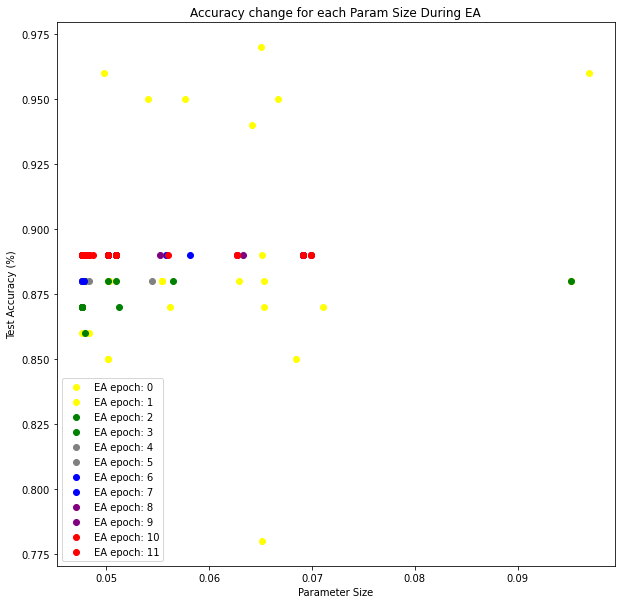

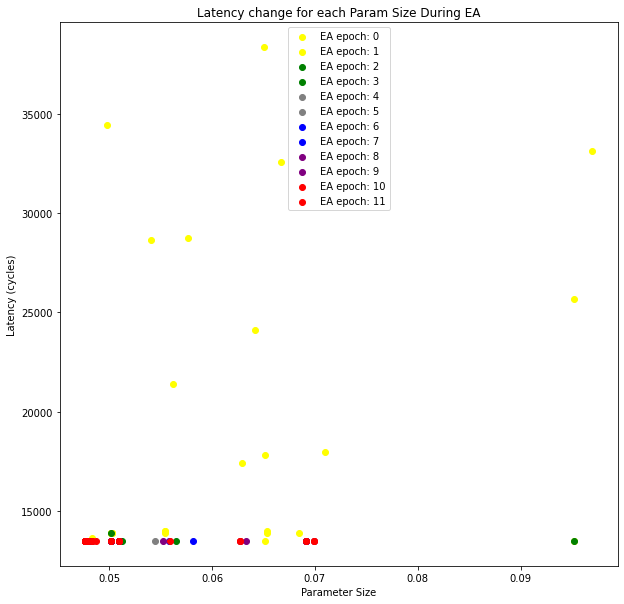

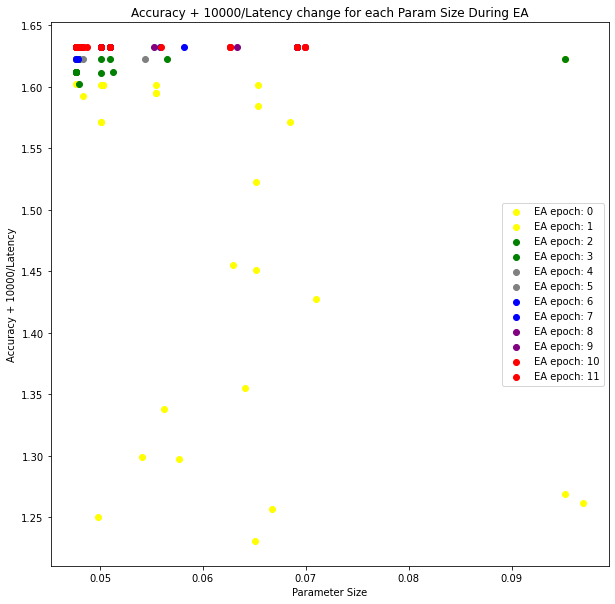

In [3]:
l = l1
acc_l = []
for i in l:
  acc_l_s = []
  for ii in i:
    acc_l_s.append(ii[0])
  acc_l.append(acc_l_s)


latency_l = []
for i in l:
  latency_l_s = []
  for ii in i:
    latency_l_s.append(ii[3])
  latency_l.append(latency_l_s)

p_l = []
for i in l:
  p_l_s = []
  for ii in i:
    p_l_s.append(ii[2])
  p_l.append(p_l_s)

c_l = []
for i in l:
  c_l_s = []
  for ii in i:
    c_l_s.append(10000/ii[3] + ii[0])
  c_l.append(c_l_s)

import matplotlib.pyplot as plt
colors = ['yellow', 'green', 'grey','blue','purple','red']
plt.figure(figsize= (10, 10))
for i in range(len(acc_l)):
  plt.scatter(p_l[i], acc_l[i], label = 'EA epoch: ' + str(i), color = colors[int(i/2)]) # , label = 'EA epoch: ' + str(i), , s=10
plt.xlabel('Parameter Size')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.title('Accuracy change for each Param Size During EA')

plt.figure(figsize= (10, 10))
for i in range(len(acc_l)):
  plt.scatter(p_l[i], latency_l[i], label = 'EA epoch: ' + str(i), color = colors[int(i/2)]) # , label = 'EA epoch: ' + str(i), , s=10
plt.xlabel('Parameter Size')
plt.ylabel('Latency (cycles)')
plt.legend()
plt.title('Latency change for each Param Size During EA')

plt.figure(figsize= (10, 10))
for i in range(len(c_l)):
  plt.scatter(p_l[i], c_l[i], label = 'EA epoch: ' + str(i), color = colors[int(i/2)]) # , label = 'EA epoch: ' + str(i), , s=10
plt.xlabel('Parameter Size')
plt.ylabel('Accuracy + 10000/Latency')
plt.legend()
plt.title('Accuracy + 10000/Latency change for each Param Size During EA')



Text(0.5, 1.0, 'Accuracy + 10000/Latency Change During Evolutionay Search')

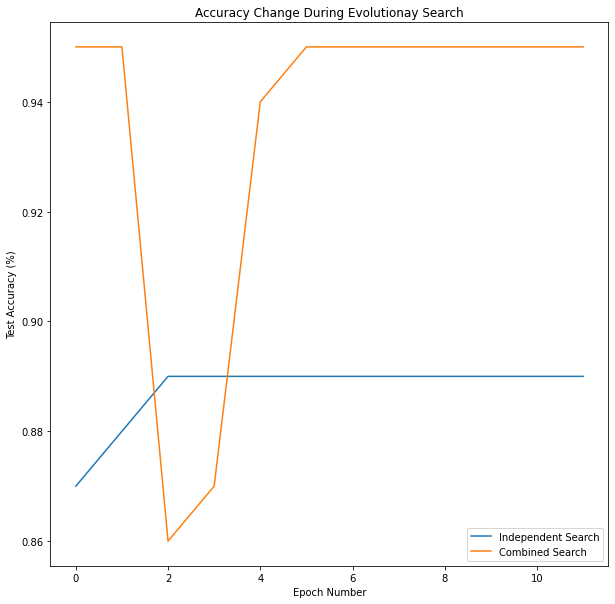

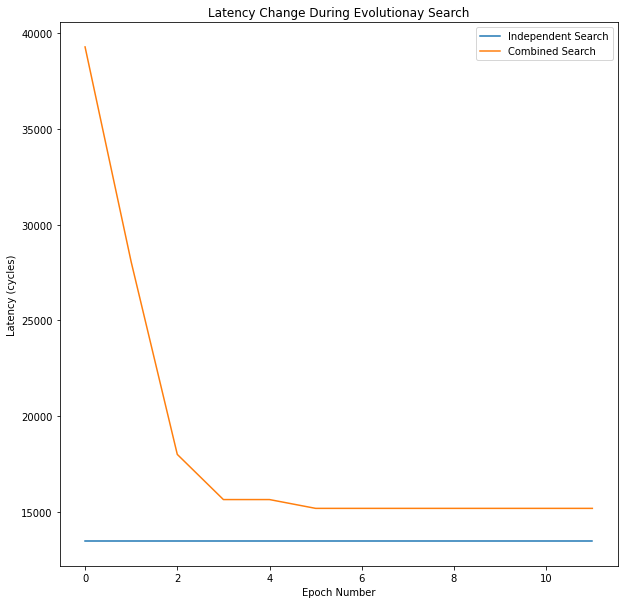

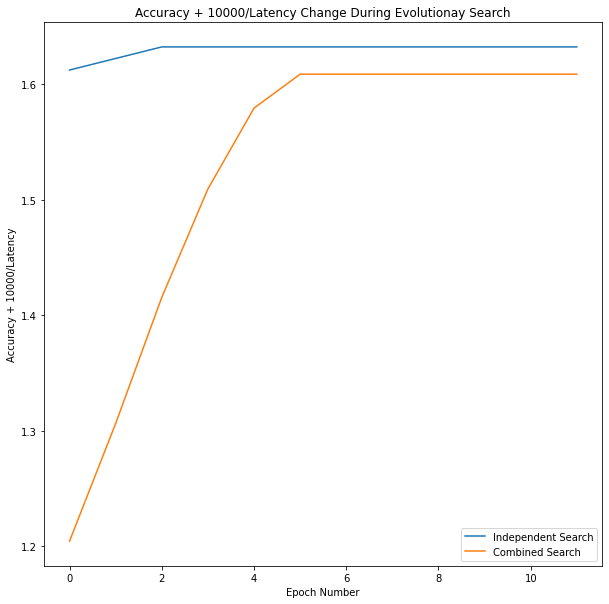

In [7]:
acc_l = []
for i in l:
  acc_l.append(i[0][0])

latency_l = []
for i in l:
  latency_l.append(i[0][3])

com_l = []
for i in l:
  com_l.append(10000/i[0][3] + i[0][0])

acc_l2 = []
for i in l2:
  acc_l2.append(i[0][0])

latency_l2 = []
for i in l2:
  latency_l2.append(i[0][3])

com_l2 = []
for i in l2:
  com_l2.append(10000/i[0][3] + i[0][0])

import matplotlib.pyplot as plt
plt.figure(figsize= (10, 10))
plt.plot(range(len(acc_l)), acc_l, label = 'Independent Search') 
plt.plot(range(len(acc_l2)), acc_l2, label = 'Combined Search') 
plt.xlabel('Epoch Number')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.title('Accuracy Change During Evolutionay Search')

plt.figure(figsize= (10, 10))
plt.plot(range(len(latency_l)), latency_l, label = 'Independent Search')
plt.plot(range(len(latency_l2)), latency_l2, label = 'Combined Search')
plt.xlabel('Epoch Number')
plt.ylabel('Latency (cycles)')
plt.legend()
plt.title('Latency Change During Evolutionay Search')

plt.figure(figsize= (10, 10))
plt.plot(range(len(latency_l)), com_l, label = 'Independent Search')
plt.plot(range(len(latency_l2)), com_l2, label = 'Combined Search')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy + 10000/Latency')
plt.legend()
plt.title('Accuracy + 10000/Latency Change During Evolutionay Search')

Results of independent search

In [ ]:
l = []